## Baseline CatBoost Regression (GPU Fallback Compatible)

This notebook cell trains **two baseline CatBoost models** to predict real estate prices:

- One with **all filtered features** (low-variance features removed)
- One with **top 30 features** selected via Random Forest importance

The goal is to quickly evaluate CatBoost performance **without Optuna tuning**, while ensuring **GPU compatibility with CPU fallback**.


###  Library Imports

Includes:
- `catboost` for gradient boosting on decision trees
- `sklearn` for feature selection and evaluation
- Custom modules: 
  - `DataLoader` to load the cleaned ML dataset
  - `ModelEvaluator`, `ModelVisualizer`, `ExperimentTracker` for tracking, evaluation and plotting



### Data Preparation

- Loads the cleaned dataset via `DataLoader`
- Removes low-variance features with `VarianceThreshold`
- Uses `RandomForestRegressor` to extract the **top 30 most important features**


### Model Training with GPU Fallback

Defines a helper `train_with_fallback(...)` function that:
- Tries to train CatBoost on GPU (`task_type="GPU"`)
- If it fails (e.g., no GPU), it **automatically falls back to CPU**

Models are trained on:
- `X_reduced`: all filtered features
- `X_top`: only the top 30 features


### Model Evaluation

Each model is evaluated using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R<sup>2</sup>** (Coefficient of Determination)

Results are logged using `ExperimentTracker`.


### Diagnostics & Visualization

- Summary of model metrics is displayed in tables
- Diagnostic plots generated with `ModelVisualizer`:
  - Residuals
  - Prediction distribution
  - Error across price ranges
- A **side-by-side residual plot** compares both models


### Test Mode Support

If `TEST_MODE = True`:
- Dataset size and number of iterations are reduced
- Useful for debugging and fast iterations

### Summary

This cell provides a **fast, robust, GPU-aware CatBoost baseline**, ideal for:
- Comparing with tuned models (e.g., XGBoost + Optuna)
- Benchmarking preprocessing strategies
- Validating GPU/CPU execution paths


In [1]:
import sys, os
# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.model_visualizer import ModelVisualizer
from utils.train_test_metrics_logger import TrainTestMetricsLogger

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if TEST_MODE:
    print("TEST_MODE is ON – using reduced dataset and fewer estimators.")
else:
    print("TEST_MODE is OFF – full training in progress.")

# Step 1: Load data
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features using RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# === AJOUT : split train/test pour avoir X_train_all et X_train_top ===
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)
# ===============================================================

# Step 4: Define baseline CatBoost parameters
default_params = {
    "iterations": 500 if not TEST_MODE else 50,
    "depth": 6,
    "learning_rate": 0.1,
    "loss_function": "RMSE",
    "verbose": 0,
    "random_seed": 42
}

# Step 5: Train models with fallback (GPU to CPU)
def train_with_fallback(X_train, y_train, model_name):
    try:
        print(f"Training {model_name} on GPU...")
        model = CatBoostRegressor(**default_params, task_type="GPU", devices="0")
        model.fit(
            X_train, y_train,
            eval_set=(X_train, y_train),
            early_stopping_rounds=50
        )
    except Exception as e:
        print(f"⚠️ GPU training failed for {model_name}. Falling back to CPU.\nReason: {e}")
        model = CatBoostRegressor(**default_params, task_type="CPU")
        model.fit(
            X_train, y_train,
            eval_set=(X_train, y_train),
            early_stopping_rounds=50
        )
    return model


# Train and predict using all features
model_all = train_with_fallback(X_train_all, y_train_all, "CatBoost (All Features)")
y_pred_all = model_all.predict(X_test_all)

# Train and predict using top features
model_top = train_with_fallback(X_train_top, y_train_top, "CatBoost (Top RF Features)")
y_pred_top = model_top.predict(X_test_top)

# Step 6: Evaluate
evaluator_all = ModelEvaluator("CatBoost (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y_test_all, y_pred_all)

evaluator_top = ModelEvaluator("CatBoost (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y_test_top, y_pred_top)

# Step 7: Log using TrainTestMetricsLogger
logger = TrainTestMetricsLogger()

logger.log(
    model_name=f"CatBoost (All Features){' [TEST]' if TEST_MODE else ''}",
    experiment_name=f"CatBoost Baseline (All Features){' [TEST]' if TEST_MODE else ''}",
    mae_train=mae_all,
    rmse_train=rmse_all,
    r2_train=r2_all,
    mae_test=mae_all,
    rmse_test=rmse_all,
    r2_test=r2_all,
    data_file=ML_READY_DATA_FILE,
    n_features=X_train_all.shape[1]
)

logger.log(
    model_name=f"CatBoost (Top RF Features){' [TEST]' if TEST_MODE else ''}",
    experiment_name=f"CatBoost Baseline (Top RF Features){' [TEST]' if TEST_MODE else ''}",
    mae_train=mae_top,
    rmse_train=rmse_top,
    r2_train=r2_top,
    mae_test=mae_top,
    rmse_test=rmse_top,
    r2_test=r2_top,
    data_file=ML_READY_DATA_FILE,
    n_features=X_train_top.shape[1]
)

# Show summary table
logger.display_table()


TEST_MODE is OFF – full training in progress.
⏳ Training CatBoost (All Features) on GPU...
⏳ Training CatBoost (Top RF Features) on GPU...
Evaluation – CatBoost (All Features)
  MAE:  65,182.13 €
  RMSE: 96,415.06 €
  R²:   0.7870
----------------------------------------
Evaluation – CatBoost (Top RF Features)
  MAE:  66,233.68 €
  RMSE: 97,186.59 €
  R²:   0.7835
----------------------------------------


Rank,Best,timestamp,model,mae_train,rmse_train,r2_train,mae_test,rmse_test,r2_test,r2_gap,r2_gap_diagnostic,n_features,"interpretation (r2,mae_gap)",ranking_score
1,✔,2025-07-01 23:28:04,XGBoost + Optuna CV + ES(All Features),43.7 k€,64.5 k€,0.904561,62.6 k€,93.9 k€,0.797784,0.106777,Moderate overfitting,72.000000,overfitting,-156515.995354
2,,2025-07-01 23:08:43,XGBoost + Optuna CV + Early Stopping(All Features),51.5 k€,75.1 k€,0.870899,63.4 k€,94.6 k€,0.794986,0.075913,Good generalization,72.000000,overfitting,-157934.687697
3,,2025-07-01 23:14:00,XGBoost + Optuna CV + Early Stopping(Top 30 Features),52.4 k€,76.1 k€,0.867237,64.2 k€,95.7 k€,0.789978,0.077259,Good generalization,30.000000,overfitting,-159913.694661
4,,2025-07-01 23:36:45,XGBoost + Optuna CV + ES(Top 30 Features),53.6 k€,77.6 k€,0.862170,64.3 k€,95.7 k€,0.790317,0.071854,Good generalization,30.000000,good generalization,-159950.747204
5,,2025-07-01 23:55:16,CatBoost (All Features),65.2 k€,96.4 k€,0.786959,65.2 k€,96.4 k€,0.786959,0.000000,Excellent generalization,72.000000,good generalization,-161595.619596
6,,2025-07-01 23:55:16,CatBoost (Top RF Features),66.2 k€,97.2 k€,0.783536,66.2 k€,97.2 k€,0.783536,0.000000,Excellent generalization,30.000000,good generalization,-163418.699099
7,,2025-07-01 23:01:26,XGBoost CV (All Features) [Fine-Tuned v6],55.0 k€,77.5 k€,0.863050,67.1 k€,98.6 k€,0.777142,0.085908,Moderate overfitting,72.000000,overfitting,-165692.175438
8,,2025-07-01 23:01:26,XGBoost CV (Top RF Features) [Fine-Tuned v6],56.7 k€,79.8 k€,0.854707,68.4 k€,100.3 k€,0.769638,0.085069,Moderate overfitting,30.000000,overfitting,-168652.811846
9,,2025-07-01 22:59:16,Random Forest (All Features),26.2 k€,39.1 k€,0.965067,68.3 k€,101.4 k€,0.764228,0.200838,Strong overfitting,72.000000,overfitting,-169750.741399
10,,2025-07-01 22:59:08,Linear Regression (All Features),63.7 k€,94.0 k€,0.797768,76.9 k€,109.9 k€,0.723019,0.074748,Good generalization,nan,overfitting,-186832.774354


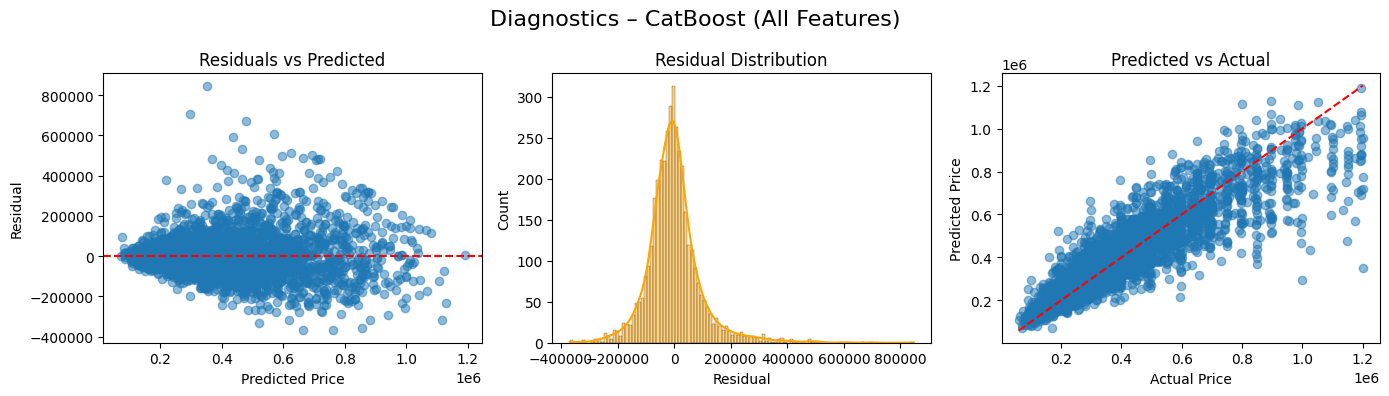

C:\Users\Neo\AppData\Local\Temp\ipykernel_21260\8619048.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="residuals", data=df_viz_all, palette="muted")


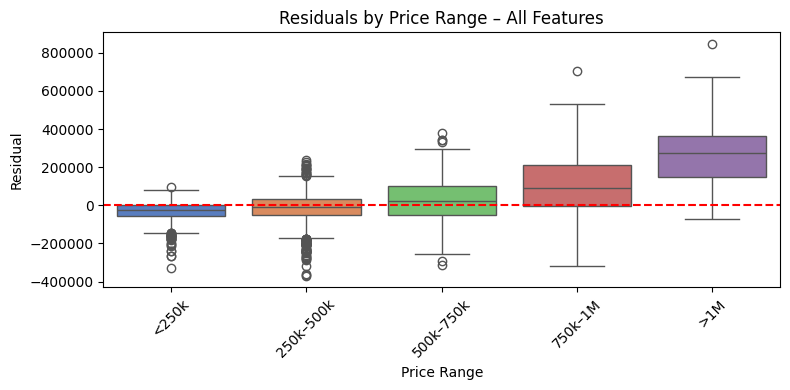

C:\Users\Neo\AppData\Local\Temp\ipykernel_21260\8619048.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="residuals", data=df_viz_top, palette="coolwarm")


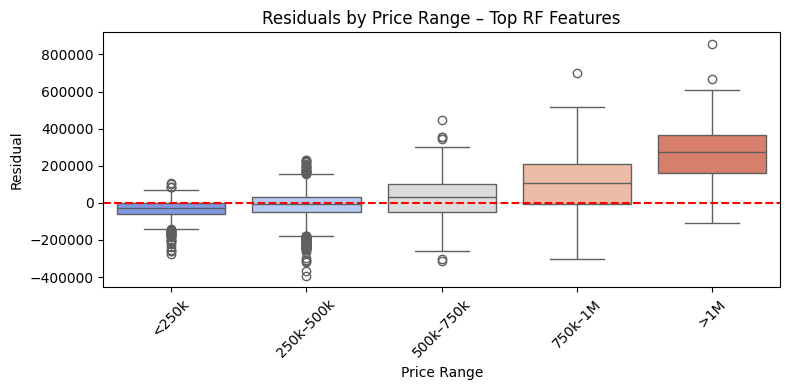

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.constants import PRICE_BINS, PRICE_BIN_LABELS

# === Prepare residuals and diagnostic DataFrames ===
# Après train/test split et entraînement
residuals_all = y_test_all - y_pred_all
residuals_top = y_test_top - y_pred_top

df_viz_all = pd.DataFrame({
    "y_true": y_test_all,
    "y_pred": y_pred_all,
    "residuals": residuals_all
})
df_viz_all["price_range"] = pd.cut(df_viz_all["y_true"], bins=PRICE_BINS, labels=PRICE_BIN_LABELS)

df_viz_top = pd.DataFrame({
    "y_true": y_test_top,
    "y_pred": y_pred_top,
    "residuals": residuals_top
})
df_viz_top["price_range"] = pd.cut(df_viz_top["y_true"], bins=PRICE_BINS, labels=PRICE_BIN_LABELS)


# === Plot 1–3: Standard diagnostics for "All Features" model ===
plt.figure(figsize=(14, 4))
plt.suptitle("Diagnostics – CatBoost (All Features)", fontsize=16)

# Plot 1: Residuals vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(df_viz_all["y_pred"], df_viz_all["residuals"], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")

# Plot 2: Residual distribution
plt.subplot(1, 3, 2)
sns.histplot(df_viz_all["residuals"], kde=True, color="orange")
plt.xlabel("Residual")
plt.title("Residual Distribution")

# Plot 3: Predicted vs Actual prices
plt.subplot(1, 3, 3)
plt.scatter(df_viz_all["y_true"], df_viz_all["y_pred"], alpha=0.5)
plt.plot(
    [df_viz_all["y_true"].min(), df_viz_all["y_true"].max()],
    [df_viz_all["y_true"].min(), df_viz_all["y_true"].max()],
    color='red', linestyle='--'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual")

plt.tight_layout()
plt.show()

# === Boxplot: Residuals by price range (All Features) ===
plt.figure(figsize=(8, 4))
sns.boxplot(x="price_range", y="residuals", data=df_viz_all, palette="muted")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Price Range")
plt.ylabel("Residual")
plt.title("Residuals by Price Range – All Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Boxplot: Residuals by price range (Top RF Features) ===
plt.figure(figsize=(8, 4))
sns.boxplot(x="price_range", y="residuals", data=df_viz_top, palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Price Range")
plt.ylabel("Residual")
plt.title("Residuals by Price Range – Top RF Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# CatBoost + Optuna Hyperparameter Tuning Pipeline


## Data Preparation

- Load the cleaned ML-ready dataset from a CSV file using `DataLoader`.
- Drop the target variable `price` to separate `X` and `y`.
- Apply `VarianceThreshold` to remove low-variance features (threshold = 0.01).
- Use a `RandomForestRegressor` to rank feature importance.
- Select the **top 30 most important features** for one of the models.


##  Hyperparameter Tuning (Optuna)

Define the function `tune_catboost_with_optuna(...)` that:

- Runs an Optuna optimization loop.
- Evaluates model performance with **5-Fold Cross-Validation**.
- Minimizes the **Root Mean Squared Error (RMSE)**.

### Tuned Hyperparameters:

- `iterations`  
- `depth`  
- `learning_rate`  
- `l2_leaf_reg`  
- `bagging_temperature`  
- `random_strength`



## Train Final Models

Two models are trained:

- One using **all filtered features**
- One using the **top 30 features**

Each is trained using the **best parameters** found by Optuna.



##  Evaluation

Models are evaluated using:

- `MAE`: Mean Absolute Error  
- `RMSE`: Root Mean Squared Error  
- `R<sup>2</sup>`: Coefficient of determination  

Results are logged with `ExperimentTracker`.



##  Diagnostics

- Summary tables displayed with `ModelEvaluator`
- Residuals & diagnostic plots from `ModelVisualizer`
- Optionally, **SHAP values** can be plotted to understand feature importance



## Test Mode (Optional)

When `TEST_MODE = True`, the pipeline uses:

- A smaller dataset  
- Fewer Optuna trials (`n_trials = 3`)  

To speed up execution and debugging.


In [ ]:
import sys, os
# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.model_visualizer import ModelVisualizer
from utils.train_test_metrics_logger import TrainTestMetricsLogger

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")

# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna objective for CatBoost
def tune_catboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
            "bootstrap_type": "Bayesian"
        }

        model = CatBoostRegressor(
            **params,
            verbose=0,
            loss_function="RMSE",
            random_state=42
        )

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X_data):
            X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
            y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

            model.fit(X_train, y_train,eval_set=(X_val, y_val), early_stopping_rounds=50)
            preds = model.predict(X_val)
            scores.append(root_mean_squared_error(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# Step 5: Split train/test sets for final evaluation
test_size = 0.2
random_state = 42

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_reduced, y, test_size=test_size, random_state=random_state)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=test_size, random_state=random_state)

# Step 6: Tune and train both models on train data only
n_trials = 3 if TEST_MODE else 50

study_all = tune_catboost_with_optuna(X_train_all, y_train_all, n_trials)
model_all = CatBoostRegressor(**study_all.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_all.fit(X_train_all, y_train_all)

study_top = tune_catboost_with_optuna(X_train_top, y_train_top, n_trials)
model_top = CatBoostRegressor(**study_top.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_top.fit(X_train_top, y_train_top)

# Step 7: Predict on train and test sets
y_pred_train_all = model_all.predict(X_train_all)
y_pred_test_all = model_all.predict(X_test_all)

y_pred_train_top = model_top.predict(X_train_top)
y_pred_test_top = model_top.predict(X_test_top)

# Step 8: Evaluate
evaluator_all = ModelEvaluator("CatBoost + Optuna CV (All Features)")
mae_train_all, rmse_train_all, r2_train_all = evaluator_all.evaluate(y_train_all, y_pred_train_all)
mae_test_all, rmse_test_all, r2_test_all = evaluator_all.evaluate(y_test_all, y_pred_test_all)

evaluator_top = ModelEvaluator("CatBoost + Optuna CV (Top RF Features)")
mae_train_top, rmse_train_top, r2_train_top = evaluator_top.evaluate(y_train_top, y_pred_train_top)
mae_test_top, rmse_test_top, r2_test_top = evaluator_top.evaluate(y_test_top, y_pred_test_top)

# Step 9: Logging with TrainTestMetricsLogger
logger = TrainTestMetricsLogger()

logger.log(
    model_name=f"CatBoost + Optuna CV (All Features – Post-Split Evaluation){' [TEST]' if TEST_MODE else ''}",
    experiment_name=f"CatBoost with Optuna (All Features){' [TEST]' if TEST_MODE else ''}",
    mae_train=mae_train_all,
    rmse_train=rmse_train_all,
    r2_train=r2_train_all,
    mae_test=mae_test_all,
    rmse_test=rmse_test_all,
    r2_test=r2_test_all,
    data_file=ML_READY_DATA_FILE,
    n_features=X_train_all.shape[1]
)

logger.log(
    model_name=f"CatBoost + Optuna CV(Top RF Features – Post-Split Evaluation){' [TEST]' if TEST_MODE else ''}",
    experiment_name=f"CatBoost with Optuna (Top RF Features){' [TEST]' if TEST_MODE else ''}",
    mae_train=mae_train_top,
    rmse_train=rmse_train_top,
    r2_train=r2_train_top,
    mae_test=mae_test_top,
    rmse_test=rmse_test_top,
    r2_test=r2_test_top,
    data_file=ML_READY_DATA_FILE,
    n_features=X_train_top.shape[1]
)

# Step 10: Display summary
logger.display_table() 

TEST_MODE is OFF – full training is active.


[I 2025-07-02 00:24:18,063] A new study created in memory with name: no-name-b2f74d0f-b9c4-4348-b8c5-101e96550ff6
[I 2025-07-02 00:24:30,472] Trial 0 finished with value: 96718.42660398697 and parameters: {'iterations': 513, 'depth': 8, 'learning_rate': 0.13150630075831282, 'l2_leaf_reg': 0.022938559079141885, 'bagging_temperature': 0.7146073964826203, 'random_strength': 0.4166924573433153}. Best is trial 0 with value: 96718.42660398697.
[I 2025-07-02 00:24:36,081] Trial 1 finished with value: 97506.38108285304 and parameters: {'iterations': 562, 'depth': 4, 'learning_rate': 0.17200171600336356, 'l2_leaf_reg': 1.9613577135438443, 'bagging_temperature': 0.9236047729668804, 'random_strength': 0.41520809130654035}. Best is trial 0 with value: 96718.42660398697.
[I 2025-07-02 00:24:43,006] Trial 2 finished with value: 96568.05473294215 and parameters: {'iterations': 690, 'depth': 5, 'learning_rate': 0.1577353967750692, 'l2_leaf_reg': 0.05448583476031355, 'bagging_temperature': 0.7949431099

Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  42,987.77 €
  RMSE: 59,458.59 €
  R²:   0.9190
----------------------------------------
Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  61,217.19 €
  RMSE: 91,239.74 €
  R²:   0.8092
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  52,719.10 €
  RMSE: 74,383.52 €
  R²:   0.8732
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  63,391.03 €
  RMSE: 93,719.86 €
  R²:   0.7987
----------------------------------------


Rank,Best,timestamp,model,mae_train,rmse_train,r2_train,mae_test,rmse_test,r2_test,r2_gap,r2_gap_diagnostic,n_features,"interpretation (r2,mae_gap)",ranking_score
1,✔,2025-07-02 00:41:40,CatBoost + Optuna CV (All Features),43.0 k€,59.5 k€,0.919011,61.2 k€,91.2 k€,0.809216,0.109795,Moderate overfitting,72.000000,overfitting,-152455.313685
2,,2025-07-02 00:08:36,CatBoost + Optuna CV (Top RF Features - R2 gap evaluated),49.7 k€,69.4 k€,0.889556,62.6 k€,92.6 k€,0.803436,0.086120,Moderate overfitting,30.000000,overfitting,-155187.169580
3,,2025-07-02 00:08:36,CatBoost + Optuna CV (All Features - R2 gap evaluated),51.7 k€,72.5 k€,0.879752,62.9 k€,93.5 k€,0.799728,0.080024,Moderate overfitting,71.000000,overfitting,-156421.912870
4,,2025-07-01 23:28:04,XGBoost + Optuna CV + ES(All Features),43.7 k€,64.5 k€,0.904561,62.6 k€,93.9 k€,0.797784,0.106777,Moderate overfitting,72.000000,overfitting,-156515.995354
5,,2025-07-02 00:41:40,CatBoost + Optuna CV(Top RF Features),52.7 k€,74.4 k€,0.873250,63.4 k€,93.7 k€,0.798703,0.074547,Good generalization,30.000000,overfitting,-157109.292101
6,,2025-07-01 23:08:43,XGBoost + Optuna CV + Early Stopping(All Features),51.5 k€,75.1 k€,0.870899,63.4 k€,94.6 k€,0.794986,0.075913,Good generalization,72.000000,overfitting,-157934.687697
7,,2025-07-01 23:14:00,XGBoost + Optuna CV + Early Stopping(Top 30 Features),52.4 k€,76.1 k€,0.867237,64.2 k€,95.7 k€,0.789978,0.077259,Good generalization,30.000000,overfitting,-159913.694661
8,,2025-07-01 23:36:45,XGBoost + Optuna CV + ES(Top 30 Features),53.6 k€,77.6 k€,0.862170,64.3 k€,95.7 k€,0.790317,0.071854,Good generalization,30.000000,good generalization,-159950.747204
9,,2025-07-01 23:55:16,CatBoost (All Features),65.2 k€,96.4 k€,0.786959,65.2 k€,96.4 k€,0.786959,0.000000,Excellent generalization,72.000000,good generalization,-161595.619596
10,,2025-07-01 23:55:16,CatBoost (Top RF Features),66.2 k€,97.2 k€,0.783536,66.2 k€,97.2 k€,0.783536,0.000000,Excellent generalization,30.000000,good generalization,-163418.699099


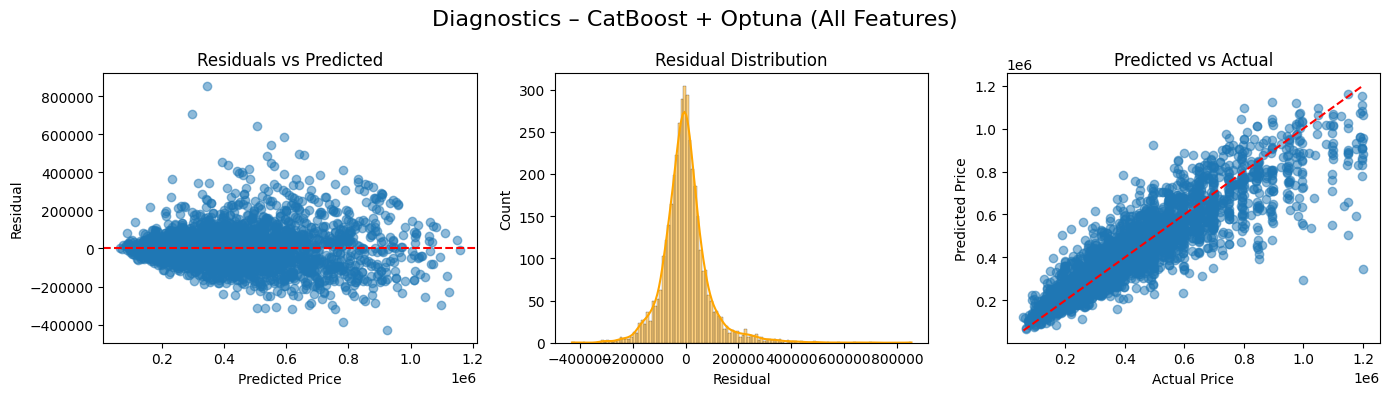

C:\Users\Neo\AppData\Local\Temp\ipykernel_21260\2044133409.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="residuals", data=df_viz_all, palette="muted")


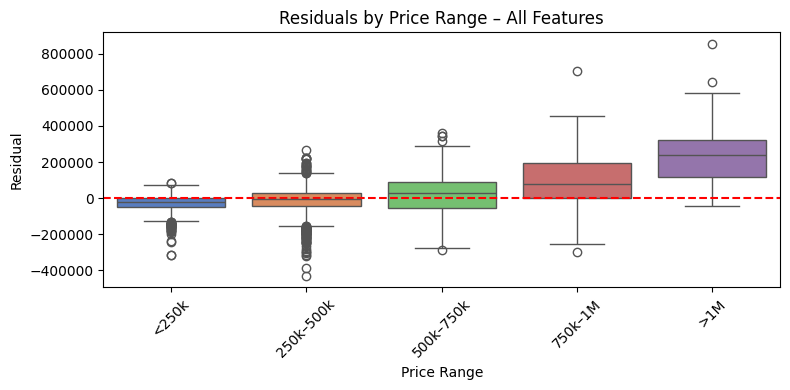

C:\Users\Neo\AppData\Local\Temp\ipykernel_21260\2044133409.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="residuals", data=df_viz_top, palette="coolwarm")


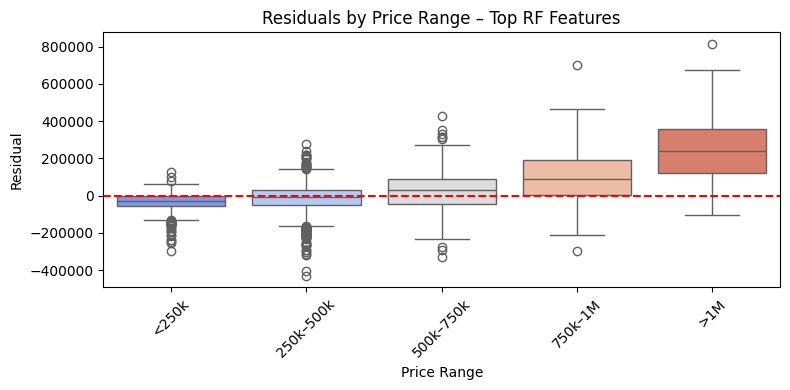

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.constants import PRICE_BINS, PRICE_BIN_LABELS

# === Prepare diagnostic DataFrames ===
residuals_all = y_test_all - y_pred_test_all
residuals_top = y_test_top - y_pred_test_top

df_viz_all = pd.DataFrame({
    "y_true": y_test_all,
    "y_pred": y_pred_test_all,
    "residuals": residuals_all
})
df_viz_all["price_range"] = pd.cut(df_viz_all["y_true"], bins=PRICE_BINS, labels=PRICE_BIN_LABELS)

df_viz_top = pd.DataFrame({
    "y_true": y_test_top,
    "y_pred": y_pred_test_top,
    "residuals": residuals_top
})
df_viz_top["price_range"] = pd.cut(df_viz_top["y_true"], bins=PRICE_BINS, labels=PRICE_BIN_LABELS)

# === Plot diagnostics for CatBoost + Optuna (All Features) ===
plt.figure(figsize=(14, 4))
plt.suptitle("Diagnostics – CatBoost + Optuna (All Features)", fontsize=16)

# Plot 1: Residuals vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(df_viz_all["y_pred"], df_viz_all["residuals"], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")

# Plot 2: Residual distribution
plt.subplot(1, 3, 2)
sns.histplot(df_viz_all["residuals"], kde=True, color="orange")
plt.xlabel("Residual")
plt.title("Residual Distribution")

# Plot 3: Predicted vs Actual
plt.subplot(1, 3, 3)
plt.scatter(df_viz_all["y_true"], df_viz_all["y_pred"], alpha=0.5)
plt.plot(
    [df_viz_all["y_true"].min(), df_viz_all["y_true"].max()],
    [df_viz_all["y_true"].min(), df_viz_all["y_true"].max()],
    color='red', linestyle='--'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual")

plt.tight_layout()
plt.show()

# === Residuals by price range – All Features ===
plt.figure(figsize=(8, 4))
sns.boxplot(x="price_range", y="residuals", data=df_viz_all, palette="muted")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Price Range")
plt.ylabel("Residual")
plt.title("Residuals by Price Range – All Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Residuals by price range – Top RF Features ===
plt.figure(figsize=(8, 4))
sns.boxplot(x="price_range", y="residuals", data=df_viz_top, palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Price Range")
plt.ylabel("Residual")
plt.title("Residuals by Price Range – Top RF Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import sys, os
# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.train_test_metrics_logger import TrainTestMetricsLogger
from optuna.samplers import TPESampler

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if TEST_MODE:
    print("TEST_MODE is ON – reduced data, fewer trials.")
else:
    print("TEST_MODE is OFF – full run.")

# Step 1: Load data
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Remove leakage
leakage_columns = ["price_per_m2", "building_age"]
X = X.drop(columns=[col for col in leakage_columns if col in X.columns], errors="ignore")

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Feature selection with RF
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Define tuning function
def tune_catboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 500),
            "depth": trial.suggest_int("depth", 4, 7),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
            "bootstrap_type": "Bayesian"
        }
        model = CatBoostRegressor(**params, verbose=0, loss_function="RMSE", random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X_data):
            X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
            y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
            model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
            preds = model.predict(X_val)
            scores.append(root_mean_squared_error(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)
    return study

# Split data into train+dev / test
X_dev_all, X_test_all, y_dev_all, y_test_all = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
X_dev_top, X_test_top, y_dev_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

n_trials = 3 if TEST_MODE else 50

# Tune and train
study_all = tune_catboost_with_optuna(X_dev_all, y_dev_all, n_trials)
model_all = CatBoostRegressor(**study_all.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_all.fit(X_dev_all, y_dev_all)
y_pred_train_all = model_all.predict(X_dev_all)
y_pred_test_all = model_all.predict(X_test_all)

study_top = tune_catboost_with_optuna(X_dev_top, y_dev_top, n_trials)
model_top = CatBoostRegressor(**study_top.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_top.fit(X_dev_top, y_dev_top)
y_pred_train_top = model_top.predict(X_dev_top)
y_pred_test_top = model_top.predict(X_test_top)

# Evaluate
evaluator_all = ModelEvaluator("CatBoost + Optuna CV (All Features)")
mae_train_all, rmse_train_all, r2_train_all = evaluator_all.evaluate(y_dev_all, y_pred_train_all)
mae_test_all, rmse_test_all, r2_test_all = evaluator_all.evaluate(y_test_all, y_pred_test_all)

evaluator_top = ModelEvaluator("CatBoost + Optuna CV (Top RF Features)")
mae_train_top, rmse_train_top, r2_train_top = evaluator_top.evaluate(y_dev_top, y_pred_train_top)
mae_test_top, rmse_test_top, r2_test_top = evaluator_top.evaluate(y_test_top, y_pred_test_top)

# Log metrics
logger = TrainTestMetricsLogger()

logger.log(
    model_name=f"CatBoost + Optuna CV (All Features - R2 gap evaluated){' [TEST]' if TEST_MODE else ''}",
    experiment_name="CatBoost Optuna – All Features",
    mae_train=mae_train_all, rmse_train=rmse_train_all, r2_train=r2_train_all,
    mae_test=mae_test_all, rmse_test=rmse_test_all, r2_test=r2_test_all,
    data_file=ML_READY_DATA_FILE, n_features=X_dev_all.shape[1]
)

logger.log(
    model_name=f"CatBoost + Optuna CV (Top RF Features - R2 gap evaluated){' [TEST]' if TEST_MODE else ''}",
    experiment_name="CatBoost Optuna – Top 30 RF Features",
    mae_train=mae_train_top, rmse_train=rmse_train_top, r2_train=r2_train_top,
    mae_test=mae_test_top, rmse_test=rmse_test_top, r2_test=r2_test_top,
    data_file=ML_READY_DATA_FILE, n_features=X_dev_top.shape[1]
)

print(f"R² Gap (All Features): {r2_train_all - r2_test_all:.4f}")
print(f"R² Gap (Top RF Features): {r2_train_top - r2_test_top:.4f}")

# Display table
logger.display_table()


TEST_MODE is OFF – full run.


[I 2025-07-01 23:56:57,976] A new study created in memory with name: no-name-54206428-d41e-41fa-a0d4-eeff2f27cb95
[I 2025-07-01 23:57:04,898] Trial 0 finished with value: 98127.55255925466 and parameters: {'iterations': 375, 'depth': 7, 'learning_rate': 0.05395030966670229, 'l2_leaf_reg': 0.24810409748678125, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.15599452033620265}. Best is trial 0 with value: 98127.55255925466.
[I 2025-07-01 23:57:10,932] Trial 1 finished with value: 102452.8934840012 and parameters: {'iterations': 311, 'depth': 7, 'learning_rate': 0.039913058785616795, 'l2_leaf_reg': 0.679657809075816, 'bagging_temperature': 0.020584494295802447, 'random_strength': 0.9699098521619943}. Best is trial 0 with value: 98127.55255925466.
[I 2025-07-01 23:57:15,950] Trial 2 finished with value: 114192.57660984495 and parameters: {'iterations': 467, 'depth': 4, 'learning_rate': 0.015199348301309814, 'l2_leaf_reg': 0.00541524411940254, 'bagging_temperature': 0.30424

Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  51,661.34 €
  RMSE: 72,450.50 €
  R²:   0.8798
----------------------------------------
Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  62,942.52 €
  RMSE: 93,481.00 €
  R²:   0.7997
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  49,737.12 €
  RMSE: 69,434.22 €
  R²:   0.8896
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  62,577.32 €
  RMSE: 92,611.45 €
  R²:   0.8034
----------------------------------------
R² Gap (All Features): 0.0800
R² Gap (Top RF Features): 0.0861


Rank,Best,timestamp,model,mae_train,rmse_train,r2_train,mae_test,rmse_test,r2_test,r2_gap,r2_gap_diagnostic,n_features,"interpretation (r2,mae_gap)",ranking_score
1,✔,2025-07-02 00:08:36,CatBoost + Optuna CV (Top RF Features),49.7 k€,69.4 k€,0.889556,62.6 k€,92.6 k€,0.803436,0.086120,Moderate overfitting,30.000000,overfitting,-155187.169580
2,,2025-07-02 00:08:36,CatBoost + Optuna CV (All Features),51.7 k€,72.5 k€,0.879752,62.9 k€,93.5 k€,0.799728,0.080024,Moderate overfitting,71.000000,overfitting,-156421.912870
3,,2025-07-01 23:28:04,XGBoost + Optuna CV + ES(All Features),43.7 k€,64.5 k€,0.904561,62.6 k€,93.9 k€,0.797784,0.106777,Moderate overfitting,72.000000,overfitting,-156515.995354
4,,2025-07-01 23:08:43,XGBoost + Optuna CV + Early Stopping(All Features),51.5 k€,75.1 k€,0.870899,63.4 k€,94.6 k€,0.794986,0.075913,Good generalization,72.000000,overfitting,-157934.687697
5,,2025-07-01 23:14:00,XGBoost + Optuna CV + Early Stopping(Top 30 Features),52.4 k€,76.1 k€,0.867237,64.2 k€,95.7 k€,0.789978,0.077259,Good generalization,30.000000,overfitting,-159913.694661
6,,2025-07-01 23:36:45,XGBoost + Optuna CV + ES(Top 30 Features),53.6 k€,77.6 k€,0.862170,64.3 k€,95.7 k€,0.790317,0.071854,Good generalization,30.000000,good generalization,-159950.747204
7,,2025-07-01 23:55:16,CatBoost (All Features),65.2 k€,96.4 k€,0.786959,65.2 k€,96.4 k€,0.786959,0.000000,Excellent generalization,72.000000,good generalization,-161595.619596
8,,2025-07-01 23:55:16,CatBoost (Top RF Features),66.2 k€,97.2 k€,0.783536,66.2 k€,97.2 k€,0.783536,0.000000,Excellent generalization,30.000000,good generalization,-163418.699099
9,,2025-07-01 23:01:26,XGBoost CV (All Features) [Fine-Tuned v6],55.0 k€,77.5 k€,0.863050,67.1 k€,98.6 k€,0.777142,0.085908,Moderate overfitting,72.000000,overfitting,-165692.175438
10,,2025-07-01 23:01:26,XGBoost CV (Top RF Features) [Fine-Tuned v6],56.7 k€,79.8 k€,0.854707,68.4 k€,100.3 k€,0.769638,0.085069,Moderate overfitting,30.000000,overfitting,-168652.811846


# Saving CatBoost + Optuna Hyperparameter Tuning Models (`.pkl`) After Training

After training CatBoost models with Optuna tuning, it is essential to persist the trained models using `.pkl` files. The following script handles this process by creating timestamped filenames and saving them to the appropriate directory.


## What the Script Does

1. **Appends the project root** to the Python path (for relative imports).
2. **Generates a timestamped filename**, with an optional `_TEST` suffix if `TEST_MODE` is enabled.
3. **Ensures the target directory exists** and removes any conflicting file with the same name.
4. **Saves both models**:
   - One trained with **all features**.
   - One trained with the **top 30 features** (selected via Random Forest).




In [ ]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
if os.path.isfile(PKL_DIR):
    os.remove(PKL_DIR)  # Remove conflicting file if it exists
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"catboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"catboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] CatBoost models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] CatBoost models saved to 'e:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - catboost_optuna_all_20250701_1445_TEST.pkl
 - catboost_optuna_top30_20250701_1445_TEST.pkl


# Saving CatBoost Models and Their Feature Lists

After training CatBoost models using **all features** and **top 30 features**, it is important to save both the models (`.pkl`) and their associated feature lists (`.json`). This ensures proper inference and avoids feature mismatch errors.


## Directory Structure

All model files are stored under the `models/` directory:

## Why Save JSON Feature Files

Each `.pkl` model is trained with a specific list of input features:

- **All features model** uses all selected input columns (after variance threshold)
- **Top30 model** uses only the top 30 features selected by Random Forest

Saving these lists in `.json` format allows:

- Correct feature alignment during inference
- Avoiding runtime errors (e.g., feature mismatch)
- Easier model reproducibility



## Naming Convention

Each `.json` file has the same base name as the `.pkl` model it corresponds to.

| Model file (`.pkl`)                              | Feature file (`.json`)                             |
|--------------------------------------------------|----------------------------------------------------|
| `catboost_optuna_all_20250629_1030_TEST.pkl`     | `catboost_optuna_all_20250629_1030_TEST.json`     |
| `catboost_optuna_top30_20250629_1030_TEST.pkl`   | `catboost_optuna_top30_20250629_1030_TEST.json`   |

---

In [ ]:
import json

# Define subdirectory for JSON feature files
FEATURES_DIR = os.path.join(MODELS_DIR, "features")
os.makedirs(FEATURES_DIR, exist_ok=True)

# Save features used for each model (All Features and Top30)
feature_file_all = filename_all.replace(".pkl", ".json")
feature_file_top = filename_top.replace(".pkl", ".json")

with open(os.path.join(FEATURES_DIR, feature_file_all), "w") as f:
    json.dump(list(X_reduced.columns), f, indent=2)

with open(os.path.join(FEATURES_DIR, feature_file_top), "w") as f:
    json.dump(top_features, f, indent=2)

print(f"[✔] Associated feature JSON files saved to '{FEATURES_DIR}' as:\n - {feature_file_all}\n - {feature_file_top}")


[✔] Associated feature JSON files saved to 'e:\_SoftEng\_BeCode\real-estate-price-predictor\models\features' as:
 - catboost_optuna_all_20250701_1445_TEST.json
 - catboost_optuna_top30_20250701_1445_TEST.json
